In [372]:
!pip install optuna
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
import re
import pickle
import gc
import optuna

# scikit-learn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# LightGBM
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [373]:
# Google Colaboratoryで作業する場合はこちらも実行してください。
from google.colab import drive
drive.mount('/content/drive')
# %cd 以降にこのnotebookを置いているディレクトリを指定してください。
%cd "/content/drive/MyDrive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [374]:
# データの読み込み
# INPUT_DIRにtrain.csvなどのデータを置いているディレクトリを指定してください。
INPUT_DIR = "/content/drive/My Drive/GCI/cmp2/"

train = pd.read_csv(INPUT_DIR + "train.csv")
test = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")

In [375]:
#ダウンサンプリング 1対10から1対4にする

# クラスごとのデータを分ける
class_0 = train[train['TARGET'] == 0]
class_1 = train[train['TARGET'] == 1]

# クラス1のサンプル数を取得
n_class_1 = len(class_1)

# クラス0をダウンサンプリングして、クラス1のサンプル数の4倍にする
n_samples_class_0 = n_class_1 * 7
class_0_downsampled = resample(class_0,
                               replace=False,  # サンプルの重複を許可しない
                               n_samples=n_samples_class_0,  # クラス1のサンプル数の4倍にする
                               random_state=42)  # 再現性のためのシード

# ダウンサンプリングされたデータとクラス1のデータを結合
train_downsampled = pd.concat([class_0_downsampled, class_1])

# シャッフルしてデータセットを混ぜる
train = train_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)


In [376]:

train['DSCR'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL'] * 100 #収入に対する年間返済額
train['Repayment_Rate'] = train['AMT_ANNUITY'] / train['AMT_CREDIT'] * 100 #返済率
train['DTI'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL'] #DTI クライアントがどれだけの負債を背負っているか
# 返済率が4.65%を超えるかどうかに基づいて新しい特徴量を作成
train['High_Repayment'] = (train['Repayment_Rate'] > 4.65).astype(int)


In [377]:

# High_Repaymentが1で、TARGETも1のデータのみをフィルタリング
target_1_high_repayment = train[(train['High_Repayment'] == 1) & (train['TARGET'] == 1)]

# High_Repaymentが1で、TARGETも1のデータ数をカウント
count_target_1 = target_1_high_repayment.shape[0]

# High Repaymentのデータの総数
count_high_repayment = train[train['High_Repayment'] == 1].shape[0]
# TARGETの全データの数
total_target_count = train['TARGET'].count()

# TARGETが1のデータの数をカウント
count_target_1_total = train[train['TARGET'] == 1].shape[0]

# 全データの数
total_count = train.shape[0]


# TARGETの総数（非欠損値の数）
total_target_count = train['TARGET'].count()

# TARGETが1の割合を計算
percentage_target_1 = (count_target_1_total / total_count) * 100

# 結果を表示
print(f"全データの中でTARGETが1のデータの数: {count_target_1_total}, TARGETの総数:{total_target_count}, 全データにおけるTARGETが1の割合: {percentage_target_1:.2f}%")
print(f"High Repaymentの中でTARGETが1のデータの数: {count_target_1}, High Repaymentの総数: {count_high_repayment}, 割合は: {count_target_1/count_high_repayment * 100:.2f}%")


全データの中でTARGETが1のデータの数: 13821, TARGETの総数:110568, 全データにおけるTARGETが1の割合: 12.50%
High Repaymentの中でTARGETが1のデータの数: 9537, High Repaymentの総数: 66569, 割合は: 14.33%


In [378]:

test['DSCR'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL'] * 100 #
test['Repayment_Rate'] = test['AMT_ANNUITY'] / test['AMT_CREDIT'] * 100 #返済率
test['DTI'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL'] * 100 #DTI クライアントがどれだけの負債を背負っているか
test['High_Repayment'] = (test['Repayment_Rate'] > 4.65).astype(int)


In [379]:
# [仮説]　外部機関によるスコアが平均的に高い方が貸し倒れリスクが低いと考えられる。
train["EXT_SOURCE_mean"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis=1)
train["EXT_SOURCE_max"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].max(axis=1)
train["EXT_SOURCE_min"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].min(axis=1)
train["EXT_SOURCE_std"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].std(axis=1)
train["EXT_SOURCE_count"] = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].notnull().sum(axis=1)

In [380]:
# [仮説]　外部機関によるスコアが平均的に高い方が貸し倒れリスクが低いと考えられる。
test["EXT_SOURCE_mean"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis=1)
test["EXT_SOURCE_max"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].max(axis=1)
test["EXT_SOURCE_min"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].min(axis=1)
test["EXT_SOURCE_std"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].std(axis=1)
test["EXT_SOURCE_count"] = test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].notnull().sum(axis=1)

In [381]:
# OWN_CAR_AGEをグループ分け
train["OWN_CAR_AGE"] = train["OWN_CAR_AGE"] // 10
test["OWN_CAR_AGE"] = test["OWN_CAR_AGE"] // 10

train["OWN_CAR_AGE"].unique()
# OWN_CAR_AGEをOne Hot Encoding
train_car_age_ohe = pd.get_dummies(train["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")
test_car_age_ohe = pd.get_dummies(test["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")

train = pd.concat([train, train_car_age_ohe], axis=1)
test = pd.concat([test, test_car_age_ohe], axis=1)

train.drop('OWN_CAR_AGE', axis=1, inplace=True)
test.drop('OWN_CAR_AGE', axis=1, inplace=True)

In [382]:
train['DOWN_PAYMENT'] = train['AMT_GOODS_PRICE'] - train['AMT_CREDIT']
test['DOWN_PAYMENT'] = test['AMT_GOODS_PRICE'] - test['AMT_CREDIT']
train['DOWN_PAYMENT_RATE'] = train['DOWN_PAYMENT'] / train['AMT_CREDIT'] * 100
test['DOWN_PAYMENT_RATE'] = test['DOWN_PAYMENT'] / test['AMT_CREDIT'] * 100
# DOWN_PAYMENT_RATEが-30以下であれば1, それ以上であれば0をセット
train['DOWN_PAYMENT_RATE_ALART'] = (train['DOWN_PAYMENT_RATE'] <=-30).astype(int) *100
test['DOWN_PAYMENT_RATE_ALART'] = (test['DOWN_PAYMENT_RATE'] <= -30).astype(int) * 100

In [383]:
train['EMPLOYMENT_TO_AGE_RATIO'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
test['EMPLOYMENT_TO_AGE_RATIO'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']

In [384]:
train['SOCIAL_CIRCLE_DEFAULT_RATE'] = train['DEF_30_CNT_SOCIAL_CIRCLE'] / train['OBS_30_CNT_SOCIAL_CIRCLE'].replace(0, 1)
test['SOCIAL_CIRCLE_DEFAULT_RATE'] = test['DEF_30_CNT_SOCIAL_CIRCLE'] / test['OBS_30_CNT_SOCIAL_CIRCLE'].replace(0, 1)

In [385]:

train_client_age = train['DAYS_BIRTH'] // 365 * (-1)
train_loan_years = train['AMT_CREDIT'] / train['AMT_ANNUITY']
test_client_age = test['DAYS_BIRTH'] // 365 * (-1)
test_loan_years = test['AMT_CREDIT'] / test['AMT_ANNUITY']
train['FINISH_AGE'] = train_client_age + train_loan_years
test['FINISH_AGE'] = test_client_age + test_loan_years


In [386]:
def calculate_w_city_rate(region_rating):
    if region_rating == 1:
        return 4.745279
    elif region_rating == 2:
        return 7.936173
    elif region_rating == 3:
        return 11.351307
    else:
        return None

train['W_CITY_RATE'] = train['REGION_RATING_CLIENT_W_CITY'].apply(calculate_w_city_rate)
test['W_CITY_RATE'] = test['REGION_RATING_CLIENT_W_CITY'].apply(calculate_w_city_rate)

In [387]:
# 'REGION_RATING_CLIENT_W_CITY' に基づいてグループ化し、'TARGET'が1の割合を計算します。
grouped = train.groupby('REGION_RATING_CLIENT')['TARGET']
target_ratio = grouped.mean() * 100  # 割合をパーセントで表示
# 結果を表示します。
print(target_ratio)

REGION_RATING_CLIENT
1     7.466952
2    12.267690
3    16.730337
Name: TARGET, dtype: float64


In [388]:
# カテゴリカルカラムの抽出
categorical_columns = train.select_dtypes(include=['object', 'category']).columns.tolist()

# 連続値カラムのリスト（仮）- TARGET カラムを除外して定義
numerical_columns = [col for col in train.columns if col not in categorical_columns + ['TARGET']]

# カテゴリカルデータのエンコーダーの初期化
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# トレーニングデータにエンコーダーを適用
train_cat = encoder.fit_transform(train[categorical_columns])
train_cat = pd.DataFrame(train_cat, columns=categorical_columns, index=train.index)

# テストデータにエンコーダーを適用
test_cat = encoder.transform(test[categorical_columns])
test_cat = pd.DataFrame(test_cat, columns=categorical_columns, index=test.index)

# カテゴリカルデータを数値データに結合
train_processed = pd.concat([train[numerical_columns], train_cat], axis=1)
test_processed = pd.concat([test[numerical_columns], test_cat], axis=1)

In [ ]:
"""
for_knn_features = ['EXT_SOURCE_mean', 'Repayment_Rate',
            'AMT_CREDIT','AMT_ANNUITY',
            'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
            'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
            'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON',
            'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
            "EXT_SOURCE_max","FINISH_AGE",
            "EXT_SOURCE_min","EXT_SOURCE_std",
            "EXT_SOURCE_count","DAYS_BIRTH",
            "DOWN_PAYMENT_RATE","DAYS_ID_PUBLISH",
            'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE',
            'EMPLOYMENT_TO_AGE_RATIO', 'AMT_GOODS_PRICE',
            'DAYS_EMPLOYED', 'DOWN_PAYMENT',
            'SK_ID_CURR','DTI',
            'DSCR'
            ]
"""

In [ ]:
"""
knn_x_train = train_processed[for_knn_features]
knn_y_train = train["TARGET"]

id_train = train_processed[["SK_ID_CURR"]]
for col in knn_x_train.columns:
    if knn_x_train[col].dtype=="O":
        knn_x_train[col] = knn_x_train[col].astype("category")

# データセットの作成
knn_x_test = test_processed[for_knn_features]
knn_id_test = test_processed["SK_ID_CURR"].copy()

# カテゴリ変数をcategory型に変換
for col in knn_x_test.columns:
    if knn_x_test[col].dtype=="O":
        knn_x_test[col] = knn_x_test[col].astype("category")

# インデックスをリセット
knn_x_train.reset_index(drop=True, inplace=True)
knn_y_train.reset_index(drop=True, inplace=True)
id_train.reset_index(drop=True, inplace=True)

# データのスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(knn_x_train)
"""

In [ ]:
"""
# kNNレグレッサーの設定
knn = KNeighborsRegressor(n_neighbors=300)

# モデルの学習
knn.fit(X_scaled, knn_y_train)

# 近傍300のTARGETの平均値の計算
knn_mean_TARGET = knn.predict(X_scaled)
knn_mean_test_TARGET = knn.predict(scaler.transform(knn_x_test))
# 新たな特徴量としてデータセットに追加
train_processed['knn_mean_TARGET'] = knn_mean_TARGET
test_processed['knn_mean_TARGET'] = knn_mean_test_TARGET
"""

In [389]:
X_train = train_processed
y_train = train["TARGET"]

id_train = train_processed[["SK_ID_CURR"]]
for col in X_train.columns:
    if X_train[col].dtype=="O":
        X_train[col] = X_train[col].astype("category")

In [390]:
# 層化分割したバリデーションのindexのリスト作成
cv = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(X_train, y_train))

# indexの確認：fold=0のtrainデータ
print("index(train):", cv[0][0])

# indexの確認：fold=0のvalidデータ
print("index(valid):", cv[0][1])

index(train): [     1      2      3 ... 110564 110565 110566]
index(valid): [     0      7      8 ... 110560 110563 110567]


In [391]:
print("categorical_columns:", categorical_columns)

categorical_columns: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']


In [392]:
nfold = 0
idx_tr, idx_va = cv[nfold][0], cv[nfold][1]

# 学習データと検証データに分離
x_tr, y_tr, id_tr = X_train.loc[idx_tr, :], y_train[idx_tr], id_train.loc[idx_tr, :]
x_va, y_va, id_va = X_train.loc[idx_va, :], y_train[idx_va], id_train.loc[idx_va, :]

# モデルの学習
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 32,
    'n_estimators': 1000,
    'max_depth': 10,
    'min_child_samples': 20,
    "random_state": 123,
    "importance_type": "gain",
}

model = lgb.LGBMClassifier(**params)

# 早期停止コールバックの作成
early_stopping_callback = lgb.early_stopping(stopping_rounds=100, verbose=True)

model.fit(x_tr, y_tr,
          eval_set=[(x_va, y_va)],
          callbacks=[early_stopping_callback]
         )

# モデルの保存
with open("model_lgb_fold0.pickle", "wb") as f:
    pickle.dump(model, f, protocol=4)

[LightGBM] [Info] Number of positive: 11057, number of negative: 77397
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.241993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6440
[LightGBM] [Info] Number of data points in the train set: 88454, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125003 -> initscore=-1.945884
[LightGBM] [Info] Start training from score -1.945884
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[329]	valid_0's auc: 0.759717


In [393]:
'''モデル評価'''
# 学習データの推論値取得とROC計算
y_tr_pred = model.predict_proba(x_tr)[:,1]
metric_tr = roc_auc_score(y_tr, y_tr_pred)

# 検証データの推論値取得とROC計算
y_va_pred = model.predict_proba(x_va)[:,1]
metric_va = roc_auc_score(y_va, y_va_pred)

# 評価値を入れる変数の作成（最初のfoldのときのみ）
metrics = []

# 評価値を格納
metrics.append([nfold, metric_tr, metric_va])

# 結果の表示
print("[auc] tr:{:.4f}, va:{:.4f}".format(metric_tr, metric_va))

[auc] tr:0.8695, va:0.7597


In [396]:
'''説明変数の重要度取得（学習したモデルから説明変数の重要度を取得）'''
# 重要度の取得
imp_fold = pd.DataFrame({"col":X_train.columns, "imp":model.feature_importances_, "nfold":nfold})
# 確認（重要度の上位10個）
display(imp_fold.sort_values("imp", ascending=False)[:30])
#display(imp_fold.sort_values("imp", ascending=False))
# 重要度を格納する5fold用データフレームの作成
imp = pd.DataFrame()
# imp_foldを5fold用データフレームに結合
imp = pd.concat([imp, imp_fold])

,col,imp,nfold
42,EXT_SOURCE_mean,53517.642819,0
39,Repayment_Rate,11363.644962,0
28,EXT_SOURCE_3,6589.587553,0
45,EXT_SOURCE_std,5582.620865,0
56,DOWN_PAYMENT_RATE,5450.748942,0
7,DAYS_BIRTH,5286.194038,0
44,EXT_SOURCE_min,5273.518360,0
10,DAYS_ID_PUBLISH,4797.891707,0
60,FINISH_AGE,4458.745239,0
43,EXT_SOURCE_max,4147.274092,0


In [356]:
# impが1000以下の列名を取得
low_importance_cols = imp[imp['imp'] <= 100]['col'].unique()

# 低重要度の特徴量名を表示
print("Low importance features (imp <= 100):", low_importance_cols)

Low importance features (imp <= 100): ['FLAG_MOBIL' 'FLAG_EMP_PHONE' 'FLAG_CONT_MOBILE' 'FLAG_EMAIL'
 'REG_REGION_NOT_LIVE_REGION' 'REG_REGION_NOT_WORK_REGION'
 'LIVE_REGION_NOT_WORK_REGION' 'AMT_REQ_CREDIT_BUREAU_HOUR'
 'OWN_CAR_AGE_2.0' 'OWN_CAR_AGE_3.0' 'OWN_CAR_AGE_4.0' 'OWN_CAR_AGE_5.0'
 'OWN_CAR_AGE_6.0' 'OWN_CAR_AGE_9.0' 'DOWN_PAYMENT_RATE_ALART'
 'W_CITY_RATE']


In [357]:
#目的関数の定義
# 探索しないハイパーパラメータ
params_base = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "bagging_freq": 1,
    "random_state": 123,
}

# 目的関数の定義
def objective(trial):
    # 探索するハイパーパラメータ
    params_tuning = {
        "num_leaves": trial.suggest_int("num_leaves", 8, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 1e-5, 1e-2, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-2, 1e+2, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-2, 1e+2, log=True),
    }
    params_tuning.update(params_base)

    # モデル学習・評価
    list_metrics = []
    cv = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(X_train, y_train))
    list_fold = [0]  # 処理高速化のために1つめのfoldのみとする。
    for nfold in list_fold:
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = X_train.loc[idx_tr, :], y_train[idx_tr]
        x_va, y_va = X_train.loc[idx_va, :], y_train[idx_va]
        model = lgb.LGBMClassifier(**params_tuning)
        # 早期停止コールバックの作成
        early_stopping_callback = lgb.early_stopping(stopping_rounds=30, verbose=True)

        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_va,y_va)],
                  callbacks=[early_stopping_callback]
                 )
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_va = roc_auc_score(y_va, y_va_pred) # 評価指標をAUCにする
        list_metrics.append(metric_va)

    # 評価指標の算出
    metrics = np.mean(list_metrics)

    return metrics

In [358]:
#最適化処理（探索の実行）
sampler = optuna.samplers.TPESampler(seed=123)
study = optuna.create_study(sampler=sampler, direction="maximize")
study.optimize(objective, n_trials=30, n_jobs=-1)

[I 2024-06-29 09:31:38,049] A new study created in memory with name: no-name-c6d13056-7afb-451d-95b4-41e16b3eaaaf


Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[180]	valid_0's auc: 0.761468


[I 2024-06-29 09:31:58,745] Trial 0 finished with value: 0.7614681003825485 and parameters: {'num_leaves': 97, 'min_child_samples': 132, 'min_sum_hessian_in_leaf': 2.999953696322861e-05, 'feature_fraction': 0.7697802698275685, 'bagging_fraction': 0.8694658723663008, 'lambda_l1': 4.499874780778827, 'lambda_l2': 0.18879516373772198}. Best is trial 0 with value: 0.7614681003825485.


Early stopping, best iteration is:
[139]	valid_0's auc: 0.756629


[I 2024-06-29 09:32:00,746] Trial 1 finished with value: 0.7566286922671335 and parameters: {'num_leaves': 192, 'min_child_samples': 70, 'min_sum_hessian_in_leaf': 3.3294262855004334e-05, 'feature_fraction': 0.8625049049562783, 'bagging_fraction': 0.7757262577624162, 'lambda_l1': 0.17322903352634744, 'lambda_l2': 2.1539215408443817}. Best is trial 0 with value: 0.7614681003825485.


Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[79]	valid_0's auc: 0.751591


[I 2024-06-29 09:32:11,294] Trial 2 finished with value: 0.7515906991702097 and parameters: {'num_leaves': 181, 'min_child_samples': 118, 'min_sum_hessian_in_leaf': 0.00022565085425049219, 'feature_fraction': 0.8038467576910164, 'bagging_fraction': 0.5258264160307486, 'lambda_l1': 0.043420977946792616, 'lambda_l2': 0.08223883864650651}. Best is trial 0 with value: 0.7614681003825485.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[196]	valid_0's auc: 0.759954


[I 2024-06-29 09:32:22,500] Trial 3 finished with value: 0.7599540792096239 and parameters: {'num_leaves': 131, 'min_child_samples': 121, 'min_sum_hessian_in_leaf': 0.00040480810558970727, 'feature_fraction': 0.6931053021352426, 'bagging_fraction': 0.8347725826969695, 'lambda_l1': 0.0991947396889834, 'lambda_l2': 65.58895329529247}. Best is trial 0 with value: 0.7614681003825485.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[174]	valid_0's auc: 0.757996


[I 2024-06-29 09:32:38,277] Trial 4 finished with value: 0.7579960324137958 and parameters: {'num_leaves': 219, 'min_child_samples': 113, 'min_sum_hessian_in_leaf': 0.0007656443633351797, 'feature_fraction': 0.9678680679876964, 'bagging_fraction': 0.8276341586489643, 'lambda_l1': 0.039404828700624, 'lambda_l2': 46.24751170143147}. Best is trial 0 with value: 0.7614681003825485.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[154]	valid_0's auc: 0.757557


[I 2024-06-29 09:32:51,751] Trial 5 finished with value: 0.7575566998358367 and parameters: {'num_leaves': 230, 'min_child_samples': 6, 'min_sum_hessian_in_leaf': 0.00012723504589694844, 'feature_fraction': 0.8152765446148644, 'bagging_fraction': 0.729697221196525, 'lambda_l1': 0.061799641190928054, 'lambda_l2': 17.57565474384597}. Best is trial 0 with value: 0.7614681003825485.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[241]	valid_0's auc: 0.760113


[I 2024-06-29 09:32:58,977] Trial 6 finished with value: 0.7601125582891141 and parameters: {'num_leaves': 68, 'min_child_samples': 61, 'min_sum_hessian_in_leaf': 0.0008014128789928108, 'feature_fraction': 0.5988209234739168, 'bagging_fraction': 0.9427071213511974, 'lambda_l1': 0.02004213914863045, 'lambda_l2': 0.020376032577663666}. Best is trial 0 with value: 0.7614681003825485.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[155]	valid_0's auc: 0.760184


[I 2024-06-29 09:33:17,954] Trial 8 finished with value: 0.7601839262275772 and parameters: {'num_leaves': 124, 'min_child_samples': 197, 'min_sum_hessian_in_leaf': 7.02552521149608e-05, 'feature_fraction': 0.6437107584898312, 'bagging_fraction': 0.7542794220564311, 'lambda_l1': 0.16217673938705343, 'lambda_l2': 4.093919832756912}. Best is trial 0 with value: 0.7614681003825485.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[199]	valid_0's auc: 0.757803


[I 2024-06-29 09:33:22,487] Trial 7 finished with value: 0.7578025892145974 and parameters: {'num_leaves': 190, 'min_child_samples': 62, 'min_sum_hessian_in_leaf': 0.00021871557972490612, 'feature_fraction': 0.7880955820816207, 'bagging_fraction': 0.9000355606629583, 'lambda_l1': 0.10964311431509403, 'lambda_l2': 28.735217314305093}. Best is trial 0 with value: 0.7614681003825485.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[240]	valid_0's auc: 0.762365


[I 2024-06-29 09:33:34,065] Trial 9 finished with value: 0.7623653507443431 and parameters: {'num_leaves': 40, 'min_child_samples': 151, 'min_sum_hessian_in_leaf': 0.0016221209372809917, 'feature_fraction': 0.8009201744104864, 'bagging_fraction': 0.9304941327128833, 'lambda_l1': 0.028684094560513573, 'lambda_l2': 0.14112525170707743}. Best is trial 9 with value: 0.7623653507443431.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[320]	valid_0's auc: 0.763554


[I 2024-06-29 09:33:53,434] Trial 11 finished with value: 0.7635542990909329 and parameters: {'num_leaves': 21, 'min_child_samples': 171, 'min_sum_hessian_in_leaf': 0.006855255325941143, 'feature_fraction': 0.9430589288161848, 'bagging_fraction': 0.9920086402431232, 'lambda_l1': 1.618699437679328, 'lambda_l2': 0.3513300303456448}. Best is trial 11 with value: 0.7635542990909329.


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.755213


[I 2024-06-29 09:34:00,945] Trial 10 finished with value: 0.7552130193667568 and parameters: {'num_leaves': 122, 'min_child_samples': 72, 'min_sum_hessian_in_leaf': 0.003550200412778895, 'feature_fraction': 0.6573372187792476, 'bagging_fraction': 0.7358690274509812, 'lambda_l1': 87.79033374536763, 'lambda_l2': 0.044831357413637404}. Best is trial 11 with value: 0.7635542990909329.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[535]	valid_0's auc: 0.763302


[I 2024-06-29 09:34:14,626] Trial 12 finished with value: 0.7633015851647427 and parameters: {'num_leaves': 10, 'min_child_samples': 179, 'min_sum_hessian_in_leaf': 0.009137536336927671, 'feature_fraction': 0.9919055412034928, 'bagging_fraction': 0.991467676604951, 'lambda_l1': 1.5547749158827344, 'lambda_l2': 0.47627638635216735}. Best is trial 11 with value: 0.7635542990909329.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[615]	valid_0's auc: 0.763212


[I 2024-06-29 09:34:25,659] Trial 13 finished with value: 0.7632115572308418 and parameters: {'num_leaves': 10, 'min_child_samples': 171, 'min_sum_hessian_in_leaf': 0.008503715527409226, 'feature_fraction': 0.9857817310558732, 'bagging_fraction': 0.9833295733171433, 'lambda_l1': 1.6028096439125514, 'lambda_l2': 0.40685506252099174}. Best is trial 11 with value: 0.7635542990909329.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[423]	valid_0's auc: 0.762792


[I 2024-06-29 09:34:35,672] Trial 14 finished with value: 0.7627922682551969 and parameters: {'num_leaves': 13, 'min_child_samples': 194, 'min_sum_hessian_in_leaf': 0.009484991131678316, 'feature_fraction': 0.9998045865896923, 'bagging_fraction': 0.9846392937708311, 'lambda_l1': 1.6676977528274728, 'lambda_l2': 0.68380026072901}. Best is trial 11 with value: 0.7635542990909329.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[404]	valid_0's auc: 0.762623


[I 2024-06-29 09:34:52,645] Trial 15 finished with value: 0.7626228512024292 and parameters: {'num_leaves': 15, 'min_child_samples': 195, 'min_sum_hessian_in_leaf': 0.006636515859598976, 'feature_fraction': 0.5043063561636802, 'bagging_fraction': 0.6211810784456859, 'lambda_l1': 10.879020390302943, 'lambda_l2': 0.9497973016451338}. Best is trial 11 with value: 0.7635542990909329.


Early stopping, best iteration is:
[243]	valid_0's auc: 0.758496
Training until validation scores don't improve for 30 rounds


[I 2024-06-29 09:34:55,187] Trial 16 finished with value: 0.7584961689047443 and parameters: {'num_leaves': 67, 'min_child_samples': 170, 'min_sum_hessian_in_leaf': 0.003280509820663692, 'feature_fraction': 0.9087422291758465, 'bagging_fraction': 0.6053578411081071, 'lambda_l1': 9.350097389087725, 'lambda_l2': 5.04025769673704}. Best is trial 11 with value: 0.7635542990909329.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[239]	valid_0's auc: 0.762271
Early stopping, best iteration is:
[232]	valid_0's auc: 0.762361


[I 2024-06-29 09:35:12,296] Trial 17 finished with value: 0.7622706297654973 and parameters: {'num_leaves': 61, 'min_child_samples': 162, 'min_sum_hessian_in_leaf': 0.0026836702545107605, 'feature_fraction': 0.9116472395523463, 'bagging_fraction': 0.9928063721086634, 'lambda_l1': 0.5121421433382644, 'lambda_l2': 5.499547014254885}. Best is trial 11 with value: 0.7635542990909329.
[I 2024-06-29 09:35:12,718] Trial 18 finished with value: 0.7623607511863493 and parameters: {'num_leaves': 50, 'min_child_samples': 157, 'min_sum_hessian_in_leaf': 0.002698860332567268, 'feature_fraction': 0.9201620807495399, 'bagging_fraction': 0.9970805157827054, 'lambda_l1': 0.4924204814770656, 'lambda_l2': 0.322920209212727}. Best is trial 11 with value: 0.7635542990909329.


Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[184]	valid_0's auc: 0.760213


[I 2024-06-29 09:35:26,114] Trial 19 finished with value: 0.7602127389059035 and parameters: {'num_leaves': 43, 'min_child_samples': 143, 'min_sum_hessian_in_leaf': 1.0683877095289069e-05, 'feature_fraction': 0.8951850462162807, 'bagging_fraction': 0.6699546448514698, 'lambda_l1': 0.48486146018347615, 'lambda_l2': 0.013739403318364731}. Best is trial 11 with value: 0.7635542990909329.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[568]	valid_0's auc: 0.755989


[I 2024-06-29 09:35:46,136] Trial 20 finished with value: 0.7559887179947423 and parameters: {'num_leaves': 86, 'min_child_samples': 96, 'min_sum_hessian_in_leaf': 0.0010468593105345048, 'feature_fraction': 0.8692550368181373, 'bagging_fraction': 0.664192762924262, 'lambda_l1': 49.5244521711556, 'lambda_l2': 0.012461155763837491}. Best is trial 11 with value: 0.7635542990909329.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[244]	valid_0's auc: 0.757472


[I 2024-06-29 09:35:50,865] Trial 21 finished with value: 0.7574723746059525 and parameters: {'num_leaves': 91, 'min_child_samples': 91, 'min_sum_hessian_in_leaf': 0.001321073899479319, 'feature_fraction': 0.9512849114278165, 'bagging_fraction': 0.9208606741861981, 'lambda_l1': 21.825328562487194, 'lambda_l2': 0.05627327697639143}. Best is trial 11 with value: 0.7635542990909329.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[434]	valid_0's auc: 0.763076


[I 2024-06-29 09:36:12,117] Trial 23 finished with value: 0.7630761320334907 and parameters: {'num_leaves': 14, 'min_child_samples': 178, 'min_sum_hessian_in_leaf': 0.006010732977514443, 'feature_fraction': 0.981292312646416, 'bagging_fraction': 0.9462250972076093, 'lambda_l1': 1.774241444072516, 'lambda_l2': 0.41099874385166446}. Best is trial 11 with value: 0.7635542990909329.


Early stopping, best iteration is:
[486]	valid_0's auc: 0.763352


[I 2024-06-29 09:36:13,396] Trial 22 finished with value: 0.7633519185392104 and parameters: {'num_leaves': 10, 'min_child_samples': 182, 'min_sum_hessian_in_leaf': 0.006499637383581835, 'feature_fraction': 0.9655125219422633, 'bagging_fraction': 0.9441310107243924, 'lambda_l1': 1.8461068770270377, 'lambda_l2': 0.38128669571780516}. Best is trial 11 with value: 0.7635542990909329.


Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[259]	valid_0's auc: 0.762894


[I 2024-06-29 09:36:29,294] Trial 24 finished with value: 0.7628938511762529 and parameters: {'num_leaves': 30, 'min_child_samples': 177, 'min_sum_hessian_in_leaf': 0.009008812154398178, 'feature_fraction': 0.9466917392764587, 'bagging_fraction': 0.8776595908982303, 'lambda_l1': 4.516178228563342, 'lambda_l2': 1.7468878280584454}. Best is trial 11 with value: 0.7635542990909329.


Early stopping, best iteration is:
[269]	valid_0's auc: 0.762929


[I 2024-06-29 09:36:30,803] Trial 25 finished with value: 0.7629290396646436 and parameters: {'num_leaves': 30, 'min_child_samples': 179, 'min_sum_hessian_in_leaf': 0.005510464566946195, 'feature_fraction': 0.8394424565763713, 'bagging_fraction': 0.8713369906466226, 'lambda_l1': 4.170764511283382, 'lambda_l2': 1.436735741450084}. Best is trial 11 with value: 0.7635542990909329.


Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[231]	valid_0's auc: 0.762082


[I 2024-06-29 09:36:46,398] Trial 26 finished with value: 0.7620815243608297 and parameters: {'num_leaves': 40, 'min_child_samples': 185, 'min_sum_hessian_in_leaf': 0.004684854983901702, 'feature_fraction': 0.8481223058988536, 'bagging_fraction': 0.9527907192865849, 'lambda_l1': 3.7704042373941262, 'lambda_l2': 0.17832771745595496}. Best is trial 11 with value: 0.7635542990909329.


Early stopping, best iteration is:
[297]	valid_0's auc: 0.762557


[I 2024-06-29 09:36:48,302] Trial 27 finished with value: 0.7625574477314456 and parameters: {'num_leaves': 28, 'min_child_samples': 144, 'min_sum_hessian_in_leaf': 0.003483557383897746, 'feature_fraction': 0.9339215326936682, 'bagging_fraction': 0.959447227668052, 'lambda_l1': 1.0114364738326407, 'lambda_l2': 0.1585987746809571}. Best is trial 11 with value: 0.7635542990909329.


Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[161]	valid_0's auc: 0.7583


[I 2024-06-29 09:37:05,738] Trial 28 finished with value: 0.7582999584917937 and parameters: {'num_leaves': 147, 'min_child_samples': 142, 'min_sum_hessian_in_leaf': 0.0019020134611067874, 'feature_fraction': 0.736468793757441, 'bagging_fraction': 0.830777189157156, 'lambda_l1': 0.6179636188855868, 'lambda_l2': 0.6233535798593183}. Best is trial 11 with value: 0.7635542990909329.


Early stopping, best iteration is:
[163]	valid_0's auc: 0.75493


[I 2024-06-29 09:37:10,866] Trial 29 finished with value: 0.7549298286945109 and parameters: {'num_leaves': 169, 'min_child_samples': 22, 'min_sum_hessian_in_leaf': 0.00215973689825311, 'feature_fraction': 0.9945257005536114, 'bagging_fraction': 0.8275460281249529, 'lambda_l1': 0.31529150002441136, 'lambda_l2': 0.6640025079680616}. Best is trial 11 with value: 0.7635542990909329.


In [359]:
#探索結果の確認
trial = study.best_trial
print("acc(best)={:.4f}".format(trial.value))
display(trial.params)

acc(best)=0.7636


{'num_leaves': 21,
 'min_child_samples': 171,
 'min_sum_hessian_in_leaf': 0.006855255325941143,
 'feature_fraction': 0.9430589288161848,
 'bagging_fraction': 0.9920086402431232,
 'lambda_l1': 1.618699437679328,
 'lambda_l2': 0.3513300303456448}

In [360]:
# データセットの作成
x_test = test_processed.copy()
id_test = test_processed["SK_ID_CURR"].copy()
x_test.drop(columns=low_importance_cols, inplace=True)

# カテゴリ変数をcategory型に変換
for col in x_test.columns:
    if x_test[col].dtype=="O":
        x_test[col] = x_test[col].astype("category")

In [361]:
# 最適なハイパーパラメータを取得
best_params = study.best_params
best_params.update(params_base)

# モデルの再訓練
cv = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(X_train, y_train))
for nfold in range(5):
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = X_train.loc[idx_tr, :], y_train[idx_tr]
    x_va, y_va = X_train.loc[idx_va, :], y_train[idx_va]
    x_tr.drop(columns=low_importance_cols, inplace=True)
    x_va.drop(columns=low_importance_cols, inplace=True)
    model = lgb.LGBMClassifier(**best_params)
    model.fit(x_tr, y_tr,
              eval_set=[(x_va, y_va)],
              callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=True)]
             )
    fname_lgb = "model_lgb_fold{}.pickle".format(nfold)
    with open(fname_lgb, "wb") as f:
        pickle.dump(model, f, protocol=4)

list_nfold=[0,1,2,3,4]

# テストデータで予測
pred = np.zeros((len(x_test), len(cv)))
for nfold in range(5):
    print("-"*20, nfold, "-"*20)
    fname_lgb = "model_lgb_fold{}.pickle".format(nfold)
    with open(fname_lgb, "rb") as f:
        model = pickle.load(f)
    pred[:, nfold] = model.predict_proba(x_test)[:, 1]

# 平均予測の計算
pred_lgb = pred.mean(axis=1)


# 平均予測の計算
pred = pd.concat([
    id_test,
    pd.DataFrame({"pred": pred.mean(axis=1)}),
], axis=1)

# 提出ファイルの作成
df_submit = pred.rename(columns={"pred": "TARGET"})
print(df_submit.shape)
display(df_submit.head())

# ファイル出力
df_submit.to_csv("submission_baseline.csv", index=None)


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[264]	valid_0's auc: 0.76188
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[231]	valid_0's auc: 0.76016
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[376]	valid_0's auc: 0.754791
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[252]	valid_0's auc: 0.764691
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[276]	valid_0's auc: 0.754202
-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
(61500, 2)


,SK_ID_CURR,TARGET
0,171202,0.053798
1,171203,0.359081
2,171204,0.274758
3,171205,0.189871
4,171206,0.310166


In [362]:
from google.colab import files
files.download('submission_baseline.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [363]:
X_train = train.drop(["TARGET"], axis=1)
y_train = train["TARGET"]

id_train = train[["SK_ID_CURR"]]
for col in X_train.columns:
    if X_train[col].dtype=="O":
        X_train[col] = X_train[col].astype("category")
# データセットの作成
x_test = test.copy()
id_test = test[["SK_ID_CURR"]].copy()
#x_test.drop(columns=low_importance_cols, inplace=True)
# カテゴリ変数をcategory型に変換
for col in x_test.columns:
    if x_test[col].dtype=="O":
        x_test[col] = x_test[col].astype("category")


In [364]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# モデルの設定
xgb_params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'n_estimators': 100,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'use_label_encoder': False  # ラベルエンコーダの警告を避けるために追加
}

x_tr, x_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(x_tr.shape)

# データをXGBoost用に変換
dtrain = xgb.DMatrix(x_tr, label=y_tr, enable_categorical=True)
dvalid = xgb.DMatrix(x_va, label=y_va, enable_categorical=True)


# モデルの訓練
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100)

# モデルの評価
y_valid_pred = xgb_model.predict(dvalid)
auc_score = roc_auc_score(y_va, y_valid_pred)
print("XGBoost AUC: {:.4f}".format(auc_score))

# テストデータをXGBoost用に変換
dtest = xgb.DMatrix(x_test, enable_categorical=True)
# テストデータで予測
pred_xgb = xgb_model.predict(dtest)

# 結果の表示（例として先頭の10件を表示）
print("Test predictions (first 10):", pred_xgb[:10])

(88454, 73)
XGBoost AUC: 0.7510
Test predictions (first 10): [0.0513533  0.24793787 0.21565157 0.17388137 0.28956205 0.05598103
 0.24201037 0.08790964 0.21504192 0.15062656]


In [365]:
X_train = train_processed.copy()
y_train = train["TARGET"].copy()

id_train = train_processed[["SK_ID_CURR"]]
for col in X_train.columns:
    if X_train[col].dtype=="O":
        X_train[col] = X_train[col].astype("category")

x_test = test_processed.copy()
id_test = test[["SK_ID_CURR"]].copy()
# カテゴリ変数をcategory型に変換
for col in x_test.columns:
    if x_test[col].dtype=="O":
        x_test[col] = x_test[col].astype("category")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 10.2 MB/s eta 0:00:00
0:	test: 0.6899926	test1: 0.6924884	best: 0.6924884 (0)	total: 304ms	remaining: 2m 31s
10:	test: 0.7338240	test1: 0.7304320	best: 0.7304320 (10)	total: 1.97s	remaining: 1m 27s
20:	test: 0.7419773	test1: 0.7361845	best: 0.7361845 (20)	total: 3.41s	remaining: 1m 17s
30:	test: 0.7477587	test1: 0.7400598	best: 0.7400598 (30)	total: 4.84s	remaining: 1m 13s
40:	test: 0.7533376	test1: 0.7442688	best: 0.7442688 (40)	total: 5.92s	remaining: 1m 6s
50:	test: 0.7572979	test1: 0.7462668	best: 0.7462668 (50)	total: 6.92s	remaining: 1m
60:	test: 0.7604230	test1: 0.7478265	best: 0.7478265 (60)	total: 8.07s	remaining: 58.1s
70:	test: 0.7632833	test1: 0.7485032	best: 0.7485032 (70)	total: 8.62s	remaining: 52.1s
80:	test: 0.7662578	test1: 0.7497476	best: 0.7497476 (80)	total: 9.1s	remaining: 47.1s
90:	test: 0.7685426	test1: 0.7502586	best: 0.7502638 (89)	total: 9.56s	remaining: 43s
100:	test: 0.7707696	test1: 0.7507755	best:

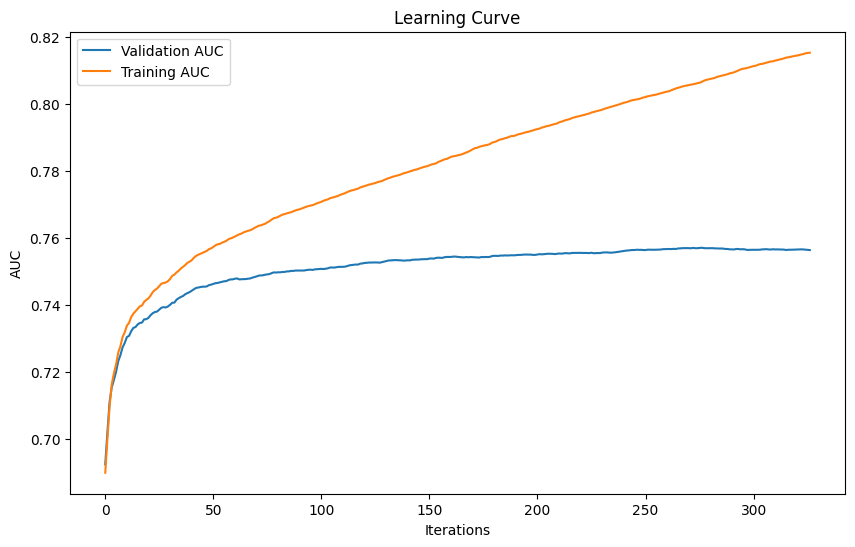

CatBoost Validation AUC: 0.7571


In [366]:
!pip install catboost
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# モデルの設定
cat_params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'verbose': 10,
    'random_seed': 42
}

x_tr, x_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# データをCatBoost用に変換
train_pool = Pool(data=x_tr, label=y_tr)
valid_pool = Pool(data=x_va, label=y_va)

# モデルの訓練
cat_model = CatBoostClassifier(**cat_params)
cat_model.fit(train_pool, eval_set=[(x_tr, y_tr), (x_va, y_va)], use_best_model=True, early_stopping_rounds=50)

# 学習曲線のプロット
evals_result = cat_model.get_evals_result()

plt.figure(figsize=(10, 6))
plt.plot(evals_result['validation_1']['AUC'], label='Validation AUC')
plt.plot(evals_result['validation_0']['AUC'], label='Training AUC')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.title('Learning Curve')
plt.legend()
plt.show()

# モデルの評価
y_valid_pred = cat_model.predict_proba(x_va)[:, 1]
auc_score = roc_auc_score(y_va, y_valid_pred)
print("CatBoost Validation AUC: {:.4f}".format(auc_score))

In [367]:
# テストデータをCatBoost用に変換
test_pool = Pool(data=x_test)

# テストデータでの予測
pred_cat = cat_model.predict_proba(test_pool)[:, 1]
print(pred_cat)

[0.04136156 0.30896819 0.25904955 ... 0.15314023 0.2032443  0.16949221]


In [368]:
# すべてのモデルの予測を平均化
#final_pred = (pred_lgb + pred_xgb + pred_cat) / 3
final_pred = (pred_lgb + pred_cat) / 2

In [369]:
# 提出ファイルの作成
submission = pd.DataFrame({
    'SK_ID_CURR': id_test['SK_ID_CURR'],
    'TARGET': final_pred
})

# ファイルの保存
submission.to_csv('submission_ensemble.csv', index=False)
from google.colab import files
files.download('submission_ensemble.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [370]:
# 各モデルから予測値を取得し、データフレームにまとめる
df_predictions = pd.DataFrame({
    'SK_ID_CURR': id_test['SK_ID_CURR'],  # テスト識別子
    'pred_lgb': pred_lgb,                 # LightGBMの予測
    'pred_xgb': pred_xgb,                 # XGBoostの予測
    'pred_cat': pred_cat                  # CatBoostの予測
})

# 予測値を全て表示
print(df_predictions)

       SK_ID_CURR  pred_lgb  pred_xgb  pred_cat
0          171202  0.053798  0.051353  0.041362
1          171203  0.359081  0.247938  0.308968
2          171204  0.274758  0.215652  0.259050
3          171205  0.189871  0.173881  0.128550
4          171206  0.310166  0.289562  0.272891
...           ...       ...       ...       ...
61495      232697  0.276629  0.308252  0.186365
61496      232698  0.053417  0.086408  0.059349
61497      232699  0.066739  0.079630  0.153140
61498      232700  0.231371  0.208478  0.203244
61499      232701  0.203892  0.249018  0.169492

[61500 rows x 4 columns]
